In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.layers import Reshape
from keras.models import Model
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import load_img, img_to_array
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras.datasets import mnist
import numpy as np
from PIL import Image
import argparse
import math

from keras.applications import VGG16, vgg16
from keras import backend as K
import keras
import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [99]:
base_image_path = "ucsd.jpg"
style_reference_image_path = "vango.jpg"

total_variation_weight = 1
style_weight = 1.0 * 100
content_weight = 0.025
width, height = load_img(base_image_path).size
img_nrows = 224
img_ncols = 224#int(width * img_nrows / height)

In [100]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img) * 1.0
    img = np.expand_dims(img, axis=0)
#     img = vgg16.preprocess_input(img) 
    return img


def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x


base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, 3, img_nrows, img_ncols))

In [101]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (0, 1, 2)))
    gram = K.dot(features, K.transpose(features))
    return gram

# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image

def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    sLoss = K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
#     print sLoss.eval()
    return sLoss

# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
    b = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    return K.sum(K.pow(a + b, 1.25))

In [102]:
def get_loss2(y_true, y_pred):
    sty = (style_reference_image)/256.0
    combo =  y_pred#vgg16.preprocess_input (y_pred * 256)
    base = (base_image)/256.0

    input_tensor = K.concatenate([base, sty, combo], axis=0)

    model = vgg16.VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
    print('Model loaded.')

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

    loss = K.variable(0.)
    layer_features = outputs_dict['block4_conv2']
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = content_weight * content_loss(base_image_features, combination_features)

    feature_layers = ['block1_conv1', 'block2_conv1','block3_conv1', 'block4_conv1','block5_conv1']
    
    for layer_name in feature_layers:
        layer_features = outputs_dict[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(feature_layers)) * sl
   
    loss += total_variation_weight * total_variation_loss(combo)
    return loss

In [103]:
# Combine generative layer with VGG layer
inputs = Input(shape=( 224*224*3, ))

# Layer 1
x1 = Dense(5, activation = 'tanh', init = 'glorot_uniform')(inputs)

# Layer 2
x = Dense(64*56*56, activation = 'tanh', init = 'glorot_uniform')(x1)
x = BatchNormalization()(x)
x = Reshape((64, 56, 56))(x)

# Layer 3
x = UpSampling2D(size = (2, 2))(x) 
x = Convolution2D(16, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# # Layer 4
# x = UpSampling2D(size = (2, 2))(x) #shape is (16, 28, 28)
# x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# # Layer 5
# x = UpSampling2D(size = (4, 4))(x) #shape is (16, 112, 112)
# x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# Layer 6
x = UpSampling2D(size = (2, 2))(x) 
out = Convolution2D(3, 5, 5, border_mode = 'same', activation = 'sigmoid')(x)


#  output shape is (None, 3, 224, 224)
generative_model = Model(input = inputs, output = out)

In [104]:
generative_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_26 (InputLayer)            (None, 150528)        0                                            
____________________________________________________________________________________________________
dense_27 (Dense)                 (None, 5)             752645      input_26[0][0]                   
____________________________________________________________________________________________________
dense_28 (Dense)                 (None, 200704)        1204224     dense_27[0][0]                   
____________________________________________________________________________________________________
batchnormalization_14 (BatchNorma(None, 200704)        401408      dense_28[0][0]                   
___________________________________________________________________________________________

In [105]:
jpgfile = Image.open("vango2.jpg")
inp = np.array(jpgfile.getdata())
inp = np.reshape(inp, (3, -1))
inpY = 1.0 * np.reshape(inp, (1, 3, 224, 224)) 


jpgfile = Image.open("vango2.jpg")
inp = np.array(jpgfile.getdata())
trainX = np.reshape(inp, (1, 3, 224, 224))
trainX2 = np.reshape(trainX, (1, np.product(trainX.shape)))
trainX3 = trainX2/256.0
print np.product(trainX.shape)
trainX3 = np.random.rand(1, 150528)

inpY = inpY/256.0

150528


In [106]:
adam_op = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
generative_model.compile(loss = get_loss2, optimizer = adam_op)

Model loaded.


Epoch 1/10
1/1 [==============================] - 0s - loss: 484383.9688
Epoch 2/10
1/1 [==============================] - 0s - loss: 483628.6562
Epoch 3/10
1/1 [==============================] - 0s - loss: 481586.1562
Epoch 4/10
1/1 [==============================] - 0s - loss: 478523.3750
Epoch 5/10
1/1 [==============================] - 0s - loss: 473388.8125
Epoch 6/10
1/1 [==============================] - 0s - loss: 464870.9062
Epoch 7/10
1/1 [==============================] - 0s - loss: 453760.9375
Epoch 8/10
1/1 [==============================] - 0s - loss: 445287.8750
Epoch 9/10
1/1 [==============================] - 0s - loss: 439141.6562
Epoch 10/10
1/1 [==============================] - 0s - loss: 431256.5000
(3, 224, 224)


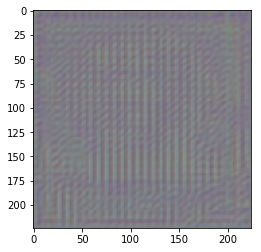

Epoch 1/10
1/1 [==============================] - 0s - loss: 421253.3438
Epoch 2/10
1/1 [==============================] - 0s - loss: 410594.9375
Epoch 3/10
1/1 [==============================] - 0s - loss: 400192.1875
Epoch 4/10
1/1 [==============================] - 0s - loss: 390179.9688
Epoch 5/10
1/1 [==============================] - 0s - loss: 380350.3750
Epoch 6/10
1/1 [==============================] - 0s - loss: 370496.2812
Epoch 7/10
1/1 [==============================] - 0s - loss: 360414.4375
Epoch 8/10
1/1 [==============================] - 0s - loss: 350049.5625
Epoch 9/10
1/1 [==============================] - 0s - loss: 339364.5938
Epoch 10/10
1/1 [==============================] - 0s - loss: 328460.3125
(3, 224, 224)


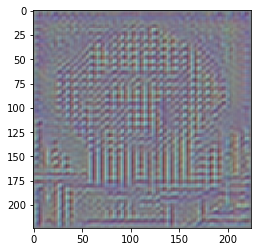

Epoch 1/10
1/1 [==============================] - 0s - loss: 317551.5938
Epoch 2/10
1/1 [==============================] - 0s - loss: 306927.2188
Epoch 3/10
1/1 [==============================] - 0s - loss: 296766.0000
Epoch 4/10
1/1 [==============================] - 0s - loss: 287053.4375
Epoch 5/10
1/1 [==============================] - 0s - loss: 277829.1250
Epoch 6/10
1/1 [==============================] - 0s - loss: 268967.9688
Epoch 7/10
1/1 [==============================] - 0s - loss: 260513.9844
Epoch 8/10
1/1 [==============================] - 0s - loss: 252568.6562
Epoch 9/10
1/1 [==============================] - 0s - loss: 245353.1875
Epoch 10/10
1/1 [==============================] - 0s - loss: 238996.5000
(3, 224, 224)


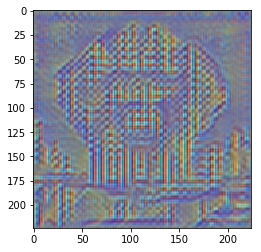

Epoch 1/10
1/1 [==============================] - 0s - loss: 233389.1406
Epoch 2/10
1/1 [==============================] - 0s - loss: 228052.8281
Epoch 3/10
1/1 [==============================] - 0s - loss: 222245.3750
Epoch 4/10
1/1 [==============================] - 0s - loss: 215623.5469
Epoch 5/10
1/1 [==============================] - 0s - loss: 208617.1406
Epoch 6/10
1/1 [==============================] - 0s - loss: 201754.8906
Epoch 7/10
1/1 [==============================] - 0s - loss: 195325.9375
Epoch 8/10
1/1 [==============================] - 0s - loss: 189306.4688
Epoch 9/10
1/1 [==============================] - 0s - loss: 183595.5312
Epoch 10/10
1/1 [==============================] - 0s - loss: 178076.4688
(3, 224, 224)


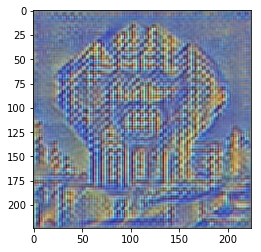

Epoch 1/10
1/1 [==============================] - 0s - loss: 172555.1562
Epoch 2/10
1/1 [==============================] - 0s - loss: 166905.4375
Epoch 3/10
1/1 [==============================] - 0s - loss: 161191.1406
Epoch 4/10
1/1 [==============================] - 0s - loss: 155545.5000
Epoch 5/10
1/1 [==============================] - 0s - loss: 150095.3281
Epoch 6/10
1/1 [==============================] - 0s - loss: 144956.2812
Epoch 7/10
1/1 [==============================] - 0s - loss: 140218.6875
Epoch 8/10
1/1 [==============================] - 0s - loss: 135931.0781
Epoch 9/10
1/1 [==============================] - 0s - loss: 132052.0000
Epoch 10/10
1/1 [==============================] - 0s - loss: 128484.4531
(3, 224, 224)


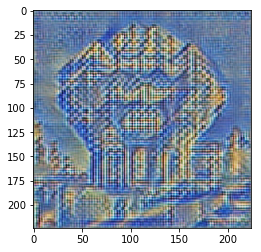

Epoch 1/10
1/1 [==============================] - 0s - loss: 125124.1172
Epoch 2/10
1/1 [==============================] - 0s - loss: 121990.6797
Epoch 3/10
1/1 [==============================] - 0s - loss: 119147.3438
Epoch 4/10
1/1 [==============================] - 0s - loss: 116639.3438
Epoch 5/10
1/1 [==============================] - 0s - loss: 114398.4375
Epoch 6/10
1/1 [==============================] - 0s - loss: 112328.5625
Epoch 7/10
1/1 [==============================] - 0s - loss: 110347.4062
Epoch 8/10
1/1 [==============================] - 0s - loss: 108431.4062
Epoch 9/10
1/1 [==============================] - 0s - loss: 106575.5078
Epoch 10/10
1/1 [==============================] - 0s - loss: 104813.2812
(3, 224, 224)


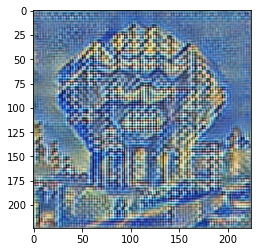

Epoch 1/10
1/1 [==============================] - 0s - loss: 103126.7578
Epoch 2/10
1/1 [==============================] - 0s - loss: 101486.6641
Epoch 3/10
1/1 [==============================] - 0s - loss: 99854.1641
Epoch 4/10
1/1 [==============================] - 0s - loss: 98252.7266
Epoch 5/10
1/1 [==============================] - 0s - loss: 96720.9062
Epoch 6/10
1/1 [==============================] - 0s - loss: 95272.8906
Epoch 7/10
1/1 [==============================] - 0s - loss: 93891.5391
Epoch 8/10
1/1 [==============================] - 0s - loss: 92565.7422
Epoch 9/10
1/1 [==============================] - 0s - loss: 91279.4141
Epoch 10/10
1/1 [==============================] - 0s - loss: 90015.4141
(3, 224, 224)


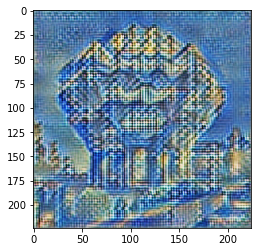

Epoch 1/10
1/1 [==============================] - 0s - loss: 88785.0234
Epoch 2/10
1/1 [==============================] - 0s - loss: 87606.9609
Epoch 3/10
1/1 [==============================] - 0s - loss: 86483.5547
Epoch 4/10
1/1 [==============================] - 0s - loss: 85395.8672
Epoch 5/10
1/1 [==============================] - 0s - loss: 84325.9141
Epoch 6/10
1/1 [==============================] - 0s - loss: 83279.7031
Epoch 7/10
1/1 [==============================] - 0s - loss: 82253.0938
Epoch 8/10
1/1 [==============================] - 0s - loss: 81251.8438
Epoch 9/10
1/1 [==============================] - 0s - loss: 80279.3438
Epoch 10/10
1/1 [==============================] - 0s - loss: 79340.3750
(3, 224, 224)


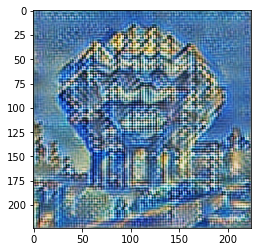

Epoch 1/10
1/1 [==============================] - 0s - loss: 78425.7656
Epoch 2/10
1/1 [==============================] - 0s - loss: 77528.5156
Epoch 3/10
1/1 [==============================] - 0s - loss: 76651.2812
Epoch 4/10
1/1 [==============================] - 0s - loss: 75798.3594
Epoch 5/10
1/1 [==============================] - 0s - loss: 74967.5938
Epoch 6/10
1/1 [==============================] - 0s - loss: 74154.4922
Epoch 7/10
1/1 [==============================] - 0s - loss: 73361.7969
Epoch 8/10
1/1 [==============================] - 0s - loss: 72590.5391
Epoch 9/10
1/1 [==============================] - 0s - loss: 71837.9531
Epoch 10/10
1/1 [==============================] - 0s - loss: 71108.3359
(3, 224, 224)


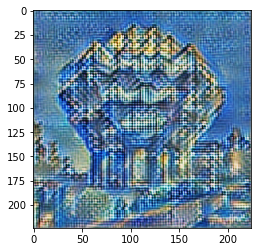

Epoch 1/10
1/1 [==============================] - 0s - loss: 70393.2891
Epoch 2/10
1/1 [==============================] - 0s - loss: 69693.5547
Epoch 3/10
1/1 [==============================] - 0s - loss: 69008.6016
Epoch 4/10
1/1 [==============================] - 0s - loss: 68336.4062
Epoch 5/10
1/1 [==============================] - 0s - loss: 67676.6875
Epoch 6/10
1/1 [==============================] - 0s - loss: 67034.2109
Epoch 7/10
1/1 [==============================] - 0s - loss: 66405.1641
Epoch 8/10
1/1 [==============================] - 0s - loss: 65792.1406
Epoch 9/10
1/1 [==============================] - 0s - loss: 65193.6953
Epoch 10/10
1/1 [==============================] - 0s - loss: 64609.2266
(3, 224, 224)


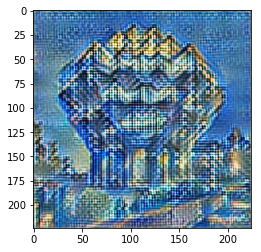

Epoch 1/10
1/1 [==============================] - 0s - loss: 64037.2383
Epoch 2/10
1/1 [==============================] - 0s - loss: 63479.7656
Epoch 3/10
1/1 [==============================] - 0s - loss: 62938.5742
Epoch 4/10
1/1 [==============================] - 0s - loss: 62411.8086
Epoch 5/10
1/1 [==============================] - 0s - loss: 61896.0547
Epoch 6/10
1/1 [==============================] - 0s - loss: 61395.5859
Epoch 7/10
1/1 [==============================] - 0s - loss: 60910.6992
Epoch 8/10
1/1 [==============================] - 0s - loss: 60437.4805
Epoch 9/10
1/1 [==============================] - 0s - loss: 59978.7656
Epoch 10/10
1/1 [==============================] - 0s - loss: 59536.7305
(3, 224, 224)


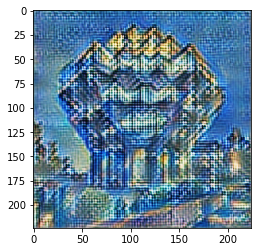

Epoch 1/10
1/1 [==============================] - 0s - loss: 59108.5547
Epoch 2/10
1/1 [==============================] - 0s - loss: 58692.4023
Epoch 3/10
1/1 [==============================] - 0s - loss: 58288.3945
Epoch 4/10
1/1 [==============================] - 0s - loss: 57894.8984
Epoch 5/10
1/1 [==============================] - 0s - loss: 57510.7578
Epoch 6/10
1/1 [==============================] - 0s - loss: 57134.6328
Epoch 7/10
1/1 [==============================] - 0s - loss: 56766.2227
Epoch 8/10
1/1 [==============================] - 0s - loss: 56405.1289
Epoch 9/10
1/1 [==============================] - 0s - loss: 56052.1641
Epoch 10/10
1/1 [==============================] - 0s - loss: 55706.7773
(3, 224, 224)


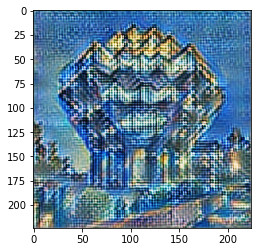

Epoch 1/10
1/1 [==============================] - 0s - loss: 55365.5547
Epoch 2/10
1/1 [==============================] - 0s - loss: 55028.2148
Epoch 3/10
1/1 [==============================] - 0s - loss: 54695.2578
Epoch 4/10
1/1 [==============================] - 0s - loss: 54367.3594
Epoch 5/10
1/1 [==============================] - 0s - loss: 54044.2930
Epoch 6/10
1/1 [==============================] - 0s - loss: 53729.7773
Epoch 7/10
1/1 [==============================] - 0s - loss: 53422.2617
Epoch 8/10
1/1 [==============================] - 0s - loss: 53120.1289
Epoch 9/10
1/1 [==============================] - 0s - loss: 52824.3672
Epoch 10/10
1/1 [==============================] - 0s - loss: 52534.6602
(3, 224, 224)


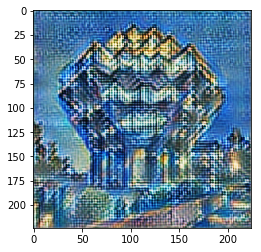

Epoch 1/10
1/1 [==============================] - 0s - loss: 52252.1953
Epoch 2/10
1/1 [==============================] - 0s - loss: 51974.8125
Epoch 3/10
1/1 [==============================] - 0s - loss: 51703.4844
Epoch 4/10
1/1 [==============================] - 0s - loss: 51437.8828
Epoch 5/10
1/1 [==============================] - 0s - loss: 51176.5859
Epoch 6/10
1/1 [==============================] - 0s - loss: 50919.3008
Epoch 7/10
1/1 [==============================] - 0s - loss: 50666.2656
Epoch 8/10
1/1 [==============================] - 0s - loss: 50417.8203
Epoch 9/10
1/1 [==============================] - 0s - loss: 50173.9375
Epoch 10/10
1/1 [==============================] - 0s - loss: 49934.6758
(3, 224, 224)


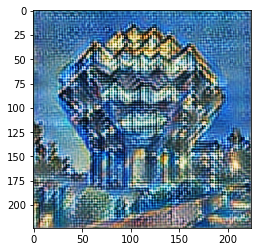

Epoch 1/10
1/1 [==============================] - 0s - loss: 49700.1445
Epoch 2/10
1/1 [==============================] - 0s - loss: 49470.8672
Epoch 3/10
1/1 [==============================] - 0s - loss: 49246.7734
Epoch 4/10
1/1 [==============================] - 0s - loss: 49028.0352
Epoch 5/10
1/1 [==============================] - 0s - loss: 48813.0938
Epoch 6/10
1/1 [==============================] - 0s - loss: 48602.6602
Epoch 7/10
1/1 [==============================] - 0s - loss: 48396.1445
Epoch 8/10
1/1 [==============================] - 0s - loss: 48193.7383
Epoch 9/10
1/1 [==============================] - 0s - loss: 47996.5312
Epoch 10/10
1/1 [==============================] - 0s - loss: 47802.7188
(3, 224, 224)


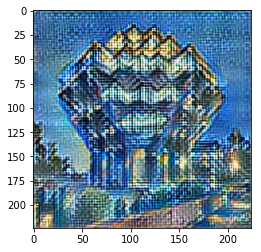

Epoch 1/10
1/1 [==============================] - 0s - loss: 47611.5625
Epoch 2/10
1/1 [==============================] - 0s - loss: 47423.7031
Epoch 3/10
1/1 [==============================] - 0s - loss: 47239.5078
Epoch 4/10
1/1 [==============================] - 0s - loss: 47058.0547
Epoch 5/10
1/1 [==============================] - 0s - loss: 46878.5859
Epoch 6/10
1/1 [==============================] - 0s - loss: 46701.1016
Epoch 7/10
1/1 [==============================] - 0s - loss: 46527.1250
Epoch 8/10
1/1 [==============================] - 0s - loss: 46356.6641
Epoch 9/10
1/1 [==============================] - 0s - loss: 46188.9219
Epoch 10/10
1/1 [==============================] - 0s - loss: 46023.0703
(3, 224, 224)


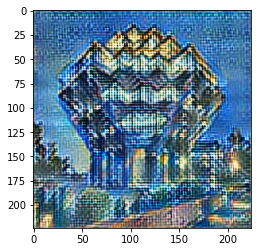

Epoch 1/10
1/1 [==============================] - 0s - loss: 45859.4062
Epoch 2/10
1/1 [==============================] - 0s - loss: 45698.3086
Epoch 3/10
1/1 [==============================] - 0s - loss: 45539.0547
Epoch 4/10
1/1 [==============================] - 0s - loss: 45381.6094
Epoch 5/10
1/1 [==============================] - 0s - loss: 45225.6406
Epoch 6/10
1/1 [==============================] - 0s - loss: 45071.7969
Epoch 7/10
1/1 [==============================] - 0s - loss: 44919.6289
Epoch 8/10
1/1 [==============================] - 0s - loss: 44769.3398
Epoch 9/10
1/1 [==============================] - 0s - loss: 44621.6406
Epoch 10/10
1/1 [==============================] - 0s - loss: 44475.6680
(3, 224, 224)


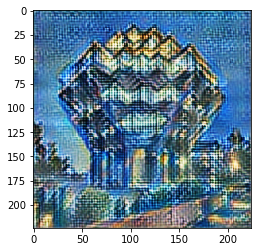

Epoch 1/10
1/1 [==============================] - 0s - loss: 44330.9570
Epoch 2/10
1/1 [==============================] - 0s - loss: 44188.5625
Epoch 3/10
1/1 [==============================] - 0s - loss: 44048.2188
Epoch 4/10
1/1 [==============================] - 0s - loss: 43908.5859
Epoch 5/10
1/1 [==============================] - 0s - loss: 43770.5391
Epoch 6/10
1/1 [==============================] - 0s - loss: 43634.5469
Epoch 7/10
1/1 [==============================] - 0s - loss: 43500.5625
Epoch 8/10
1/1 [==============================] - 0s - loss: 43368.4297
Epoch 9/10
1/1 [==============================] - 0s - loss: 43237.6797
Epoch 10/10
1/1 [==============================] - 0s - loss: 43108.2109
(3, 224, 224)


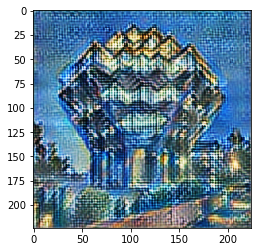

Epoch 1/10
1/1 [==============================] - 0s - loss: 42980.6836
Epoch 2/10
1/1 [==============================] - 0s - loss: 42854.7930
Epoch 3/10
1/1 [==============================] - 0s - loss: 42730.4023
Epoch 4/10
1/1 [==============================] - 0s - loss: 42607.9180
Epoch 5/10
1/1 [==============================] - 0s - loss: 42486.9922
Epoch 6/10
1/1 [==============================] - 0s - loss: 42367.0430
Epoch 7/10
1/1 [==============================] - 0s - loss: 42248.1523
Epoch 8/10
1/1 [==============================] - 0s - loss: 42130.3203
Epoch 9/10
1/1 [==============================] - 0s - loss: 42013.5547
Epoch 10/10
1/1 [==============================] - 0s - loss: 41897.6758
(3, 224, 224)


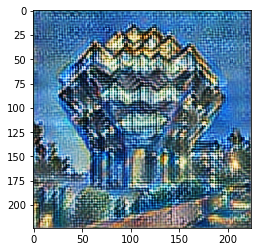

Epoch 1/10
1/1 [==============================] - 0s - loss: 41782.6680
Epoch 2/10
1/1 [==============================] - 0s - loss: 41669.5391
Epoch 3/10
1/1 [==============================] - 0s - loss: 41557.7617
Epoch 4/10
1/1 [==============================] - 0s - loss: 41447.6445
Epoch 5/10
1/1 [==============================] - 0s - loss: 41338.6797
Epoch 6/10
1/1 [==============================] - 0s - loss: 41231.2422
Epoch 7/10
1/1 [==============================] - 0s - loss: 41125.3359
Epoch 8/10
1/1 [==============================] - 0s - loss: 41021.2695
Epoch 9/10
1/1 [==============================] - 0s - loss: 40918.0312
Epoch 10/10
1/1 [==============================] - 0s - loss: 40815.3477
(3, 224, 224)


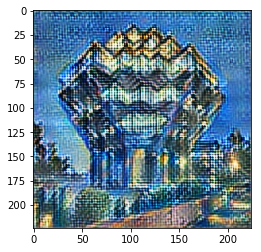

In [107]:
for i in range(20):
    generative_model.fit(trainX3, inpY, nb_epoch = 10)
    img = generative_model.predict(trainX3)
    img = img[0]
    print img.shape
    img = img.swapaxes(0, 2).swapaxes(0, 1)
    plt.imshow(img)
    plt.show()

In [97]:
jpgfile = Image.open("orig.jpg")
inp = np.array(jpgfile.getdata())
trainX = np.reshape(inp, (1, 3, 224, 224))
trainX2 = np.reshape(trainX, (1, np.product(trainX.shape)))
trainX3 = trainX2/256.0
print np.product(trainX.shape)
trainX3 = np.random.rand(1, 150528)

150528


(3, 224, 224)


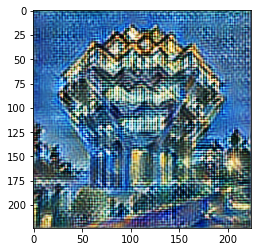

In [98]:
# generative_model.fit(trainX3, inpY, nb_epoch = 10)
img = generative_model.predict(trainX3)
img = img[0]
print img.shape
img = img.swapaxes(0, 2).swapaxes(0, 1)
plt.imshow(img)
plt.savefig('styletsfr.jpg')
# plt.show()